In [13]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline 

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [14]:
# Target Account
target_user = "@BBCWorld"

# Counter
counter = 1

# Variables for holding sentiments
sentiments = []

# Variable for max_id
oldest_tweet = None

# Loop through 5 pages of tweets (total 100 tweets)
for x in range(5):

    # Get all tweets from home feed
    public_tweets = api.user_timeline(target_user, max_id = oldest_tweet)

    # Loop through all tweets 
    for tweet in public_tweets:

        # Print Tweets
        # print("Tweet {counter}: {tweet["text"]})
        
        # Run Vader Analysis on each tweet
        results = analyzer.polarity_scores(tweet["text"])
        compound = results["compound"]
        pos = results["pos"]
        neu = results["neu"]
        neg = results["neg"]
        
        # Get Tweet ID, subtract 1, and assign to oldest_tweet
        oldest_tweet = tweet['id'] - 1
        
        # Add sentiments for each tweet into a list
        sentiments.append({"Date": tweet["created_at"], 
                           "Compound": compound,
                           "Positive": pos,
                           "Negative": neu,
                           "Neutral": neg,
                           "Tweets Ago": counter})
        
        # Add to counter 
        counter += 1

In [15]:
# Convert sentiments to DataFrame
sentiments_pd = pd.DataFrame.from_dict(sentiments)
sentiments_pd.head()

,Compound,Date,Negative,Neutral,Positive,Tweets Ago
0,-0.3182,Sun Jul 15 00:34:00 +0000 2018,0.753,0.247,0.0,1
1,0.0000,Sun Jul 15 00:26:13 +0000 2018,1.000,0.000,0.0,2
2,0.0000,Sat Jul 14 23:37:43 +0000 2018,1.000,0.000,0.0,3
3,-0.4404,Sat Jul 14 23:34:38 +0000 2018,0.698,0.302,0.0,4
4,0.0000,Sat Jul 14 23:17:30 +0000 2018,1.000,0.000,0.0,5


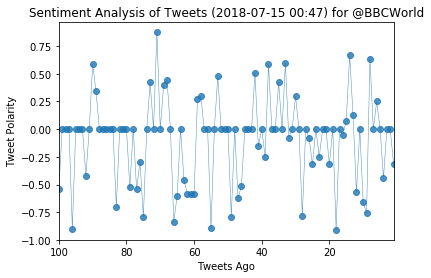

In [16]:
# Create plot
x_vals = sentiments_pd["Tweets Ago"]
y_vals = sentiments_pd["Compound"]
plt.plot(x_vals,
         y_vals, marker="o", linewidth=0.5,
         alpha=0.8)

# # Incorporate the other graph properties
now = datetime.now()
now = now.strftime("%Y-%m-%d %H:%M")
plt.title(f"Sentiment Analysis of Tweets ({now}) for {target_user}")
plt.xlim([x_vals.max(),x_vals.min()]) 
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")
plt.show()

The tweets for BBC World seem to be more negative that positive in tone according to this plot. 

In [17]:
# Target Account
user_list = ["@BBCWorld", "@FoxNews", "@CNN", "@nytimes", "@CBSNews"]
labels = ["BBC World", "Fox News", "CNN", "NY Times", "CBS News"]

def analyze_tweets(username):
    # Counter
    counter = 1

    # Variables for holding sentiments
    sentiments = []

    # Variable for max_id
    oldest_tweet = None

    # Loop through 5 pages of tweets (total 100 tweets)
    for x in range(5):

        # Get all tweets from home feed
        public_tweets = api.user_timeline(username, max_id = oldest_tweet)

        # Loop through all tweets 
        for tweet in public_tweets:

            # Run Vader Analysis on each tweet
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]

            # Get Tweet ID, subtract 1, and assign to oldest_tweet
            oldest_tweet = tweet['id'] - 1

            # Add sentiments for each tweet into a list
            sentiments.append({username: compound,
                               "Tweets Ago": counter})
            # Add to counter 
            counter += 1

    # Convert sentiments to DataFrame
    return pd.DataFrame.from_dict(sentiments)

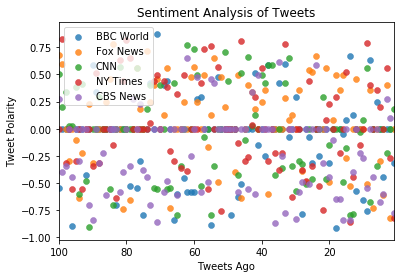

<Figure size 432x288 with 0 Axes>

In [18]:
i = 0
for username in user_list:
    sentiments = analyze_tweets(username)

    # Create plot
    x_vals = sentiments["Tweets Ago"]
    y_vals = sentiments[username]
    plt.scatter(x_vals,
             y_vals, marker="o", linewidth=0.5,
             alpha=0.8, label = labels[i])
    i += 1

# # Incorporate the other graph properties
now = datetime.now()
now = now.strftime("%Y-%m-%d %H:%M")
plt.title(f"Sentiment Analysis of Tweets")
plt.xlim([x_vals.max(),x_vals.min()]) 
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")
plt.legend()

plt.show()
plt.savefig("NewsMood_Scatter.png")


This plot is hard to read because there are points everywhere, and it looks like the mood is consistent in the negative, positive, and neutral scale for each of the news types. 

In [19]:
avg_sentiments = []

for username in user_list:
    sentiments = analyze_tweets(username)

    # Create plot
    avg_sentiments.append(sentiments[username].mean())
print(avg_sentiments)
    

[-0.08843800000000002, 0.064007, -0.027876000000000022, 0.019166000000000002, -0.19530500000000003]


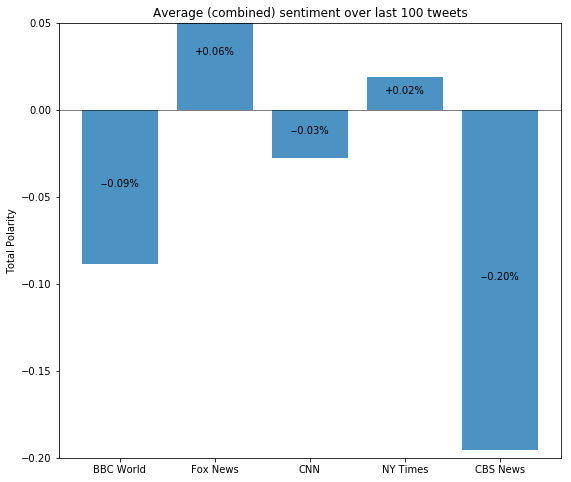

In [20]:
# Create plot
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111)
barlist = ax.bar([0,1,2,3,4], avg_sentiments, alpha=0.8)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(labels)
ax.set_ylim([-0.2,0.05])
ax.set_title("Average (combined) sentiment over last 100 tweets")
ax.set_ylabel("Total Polarity")
ax.axhline(0, c='black', linewidth=0.5)

for n in range(len(avg_sentiments)):
    y = avg_sentiments[n]
    x = n
    if (y > 0):
        ax.text(x,y/2, "+%.2f%%" % (y), ha='center') 
    else:
        ax.text(x,y/2, "-%.2f%%" % (y), ha='center') 
    
fig.savefig("Average_sentiment.png")

It seems that CBS News has the most negative tweets. However, NYT and Fox News seems to be doing better today with more positive tweets. 

In [21]:
tweet_sentiment = {}
i = 0
for username in user_list:
    sentiments = analyze_tweets(username)
    tweet_sentiment[username] = sentiments[username] 
    
tweet_sentiment['Tweets Ago'] = sentiments['Tweets Ago']
pd.DataFrame.from_dict(tweet_sentiment).to_csv("NewsMood.csv")
    